In [1]:
%reload_ext dotenv
%dotenv
%reload_ext autoreload
%autoreload 2

In [2]:
import replicate
import requests
from PIL import Image
from tqdm.notebook import tqdm

In [2]:
humans = {
    "model": {"name": "model", "image_path": "../images/humans/model.jpg"},
    "nimo": {"name": "nimo", "image_path": "../images/humans/nimo_underwear.jpg"},
}
garments = {
    "tshirt": {
        "name": "tshirt",
        "description": "purple t-shirt",
        "category": "upper_body",
        "image_path": "../images/garments/tops/tshirt.webp",
    },
    "sweater": {
        "name": "sweater",
        "description": "oversized pink sweater",
        "category": "upper_body",
        "image_path": "../images/garments/tops/sweater.jpg",
    },
    "striped_sweater": {
        "name": "striped_sweater",
        "description": "black and white striped sweater",
        "category": "upper_body",
        "image_path": "../images/garments/tops/striped_sweater.webp",
    },
    "winter_coat": {
        "name": "winter_coat",
        "description": "winter coat with fur lined hood",
        "category": "upper_body",
        "image_path": "../images/garments/tops/winter_coat.webp",
    },
    "raincoat": {
        "name": "raincoat",
        "description": "light blue hip-length raincoat",
        "category": "upper_body",
        "image_path": "../images/garments/tops/raincoat.webp",
    },
    "jeans": {
        "name": "jeans",
        "description": "slim fit washed jeans",
        "category": "lower_body",
        "image_path": "../images/garments/bottoms/jeans.webp",
    },
    "joggers": {
        "name": "joggers",
        "description": "pink joggers",
        "category": "lower_body",
        "image_path": "../images/garments/bottoms/joggers.jpg",
    },
    "gym_shorts": {
        "name": "gym_shorts",
        "description": "short white gym shorts",
        "category": "lower_body",
        "image_path": "../images/garments/bottoms/gym_shorts.webp",
    }
}

In [3]:
from sqlmodel import SQLModel, Session

from wardrobe.db import engine
from wardrobe.models import Wearable, WearableImage


# SQLModel.metadata.create_all(engine)

with Session(engine) as session:
    for garment in garments.values():
        with open(garment["image_path"], "rb") as image_file:
            wearable_image = WearableImage(image_data=image_file.read())
            session.add(wearable_image)

        wearable = Wearable(
            category=garment["category"],
            description=garment["description"],
            wearable_image_id=wearable_image.id,
        )
        session.add(wearable)
    session.commit()

2024-11-07 11:08:00,689 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-11-07 11:08:00,691 INFO sqlalchemy.engine.Engine INSERT INTO wearable (id, category, description, wearable_image_id) VALUES (?, ?, ?, ?)
2024-11-07 11:08:00,691 INFO sqlalchemy.engine.Engine [generated in 0.00042s] [('93dfeb514ec543b89fc938ca23df2152', 'upper_body', 'purple t-shirt', '82ad3f56762a454a91cfba58e763d2ad'), ('2e9b59da46bf46d39ed5eaa27dbd2084', 'upper_body', 'oversized pink sweater', 'fa91df069fe143d3864b3027bc5672d8'), ('3f79d95cf91a408d8d0b59660642d7f9', 'upper_body', 'black and white striped sweater', '39568466e50b48a29f6fdf3a72cb57f2'), ('c148c580a5074da2a03d887aa9a14727', 'upper_body', 'winter coat with fur lined hood', '3c8c8be7a08d4909a0fcfcf19fb0fa90'), ('82c0621763514e43b7b1a8c784c27258', 'upper_body', 'light blue hip-length raincoat', '6c943a06e8ec411390db6bc7c8ac850e'), ('07ece83e4daf42f09890d4dc3ae909b9', 'lower_body', 'slim fit washed jeans', '844c9f613c3d4537b497cdfcb82e25c4'), ('cd566

### Figure out where to draw the garment (pre-masking)

Only need to do this once per category/human combination

In [10]:
def generate_mask(category, human):
    input = {
        # Garment doesn't matter if mask_only is True
        "garm_img": open(next(iter(garments.values()))["image_path"], "rb"),
        "human_img": open(human["image_path"], "rb"),
        "category": category,
        "mask_only": True,
    }

    result_url = replicate.run(
        "cuuupid/idm-vton:c871bb9b046607b680449ecbae55fd8c6d945e0a1948644bf2361b3d021d3ff4",
        input=input,
    )
    
    return Image.open(requests.get(result_url, stream=True).raw)

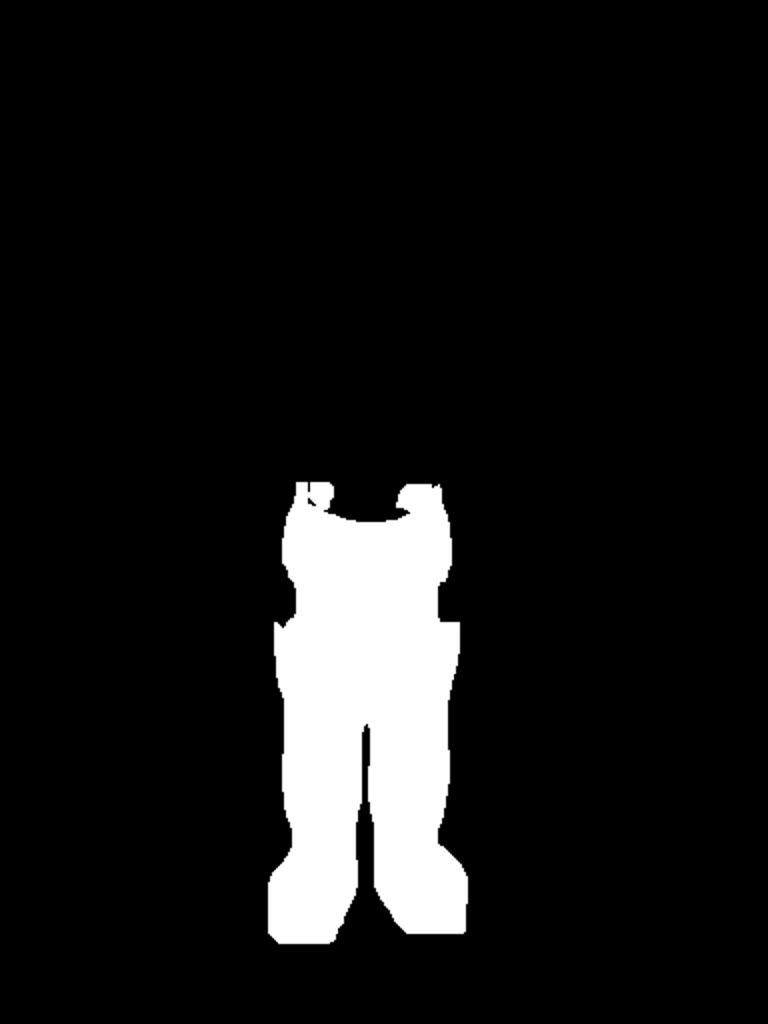

In [25]:
im = generate_mask(category="lower_body", human=humans["nimo"])
im.save(f"../images/masks/{humans["nimo"]["name"]}/pre/bottom.jpg")
im

### Put single garment on human

Needs a pre-mask for the given category/human combination

In [5]:
def put_garment(garment, human):
    input = {
        "garm_img": open(garment["image_path"], "rb"),
        "human_img": open(human["image_path"], "rb"),
        "mask_img": open(
            f"../images/masks/{human["name"]}/pre/top.jpg"
            if garment["category"] == "upper_body"
            else f"../images/masks/{human["name"]}/pre/bottom.jpg",
            "rb",
        ),
        "garment_des": garment["description"],
        "category": garment["category"],
    }

    result_url = replicate.run(
        "cuuupid/idm-vton:c871bb9b046607b680449ecbae55fd8c6d945e0a1948644bf2361b3d021d3ff4",
        input=input,
    )

    return Image.open(requests.get(result_url, stream=True).raw)

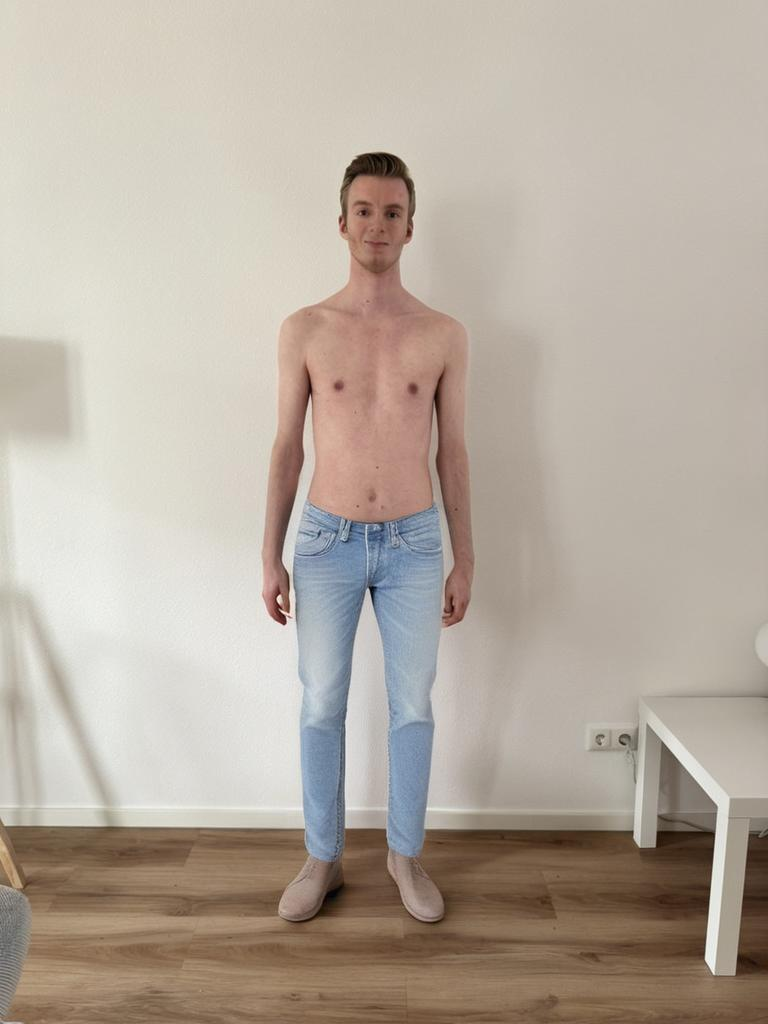

In [28]:
garment = garments["jeans"]
human = humans["nimo"]

im = put_garment(garment, human)
im.save(f"../images/results/{human["name"]}/single/{garment["name"]}.jpg")
im

In [6]:
human = humans["nimo"]
for garment in tqdm(garments.values()):
    im = put_garment(garment, human)
    im.save(f"../images/results/{human["name"]}/single/{garment["name"]}.jpg")

  0%|          | 0/8 [00:00<?, ?it/s]

### Find out where the top garment was drawn (post-masking)

Needs to be done for every top garment/human combination

In [8]:
def mask_garment(garment, human):
    prompt = garment["description"]
    print(f"prompt: {repr(prompt)}")

    negative_prompt = "underwear, shoes"
    if garment["category"] == "upper_body":
        negative_prompt = "pants, " + negative_prompt
    else:
        negative_prompt = "top, " + negative_prompt
    print(f"negative_prompt: {repr(negative_prompt)}")


    input = {
        "image": open(f"../images/results/{human["name"]}/single/{garment["name"]}.jpg", "rb"),
        "mask_prompt": prompt,
        "negative_mask_prompt": negative_prompt,
        "adjustment_factor": 0
    }

    results = replicate.run(
        "schananas/grounded_sam:ee871c19efb1941f55f66a3d7d960428c8a5afcb77449547fe8e5a3ab9ebc21c",
        input=input
    )
    for result in results:
        print(f"result: {repr(result)}")
        # Results contains some other stuff, we only want the regular mask
        if result.endswith("/mask.jpg"):
            return Image.open(requests.get(result, stream=True).raw)
    raise ValueError("Could not get mask URL")

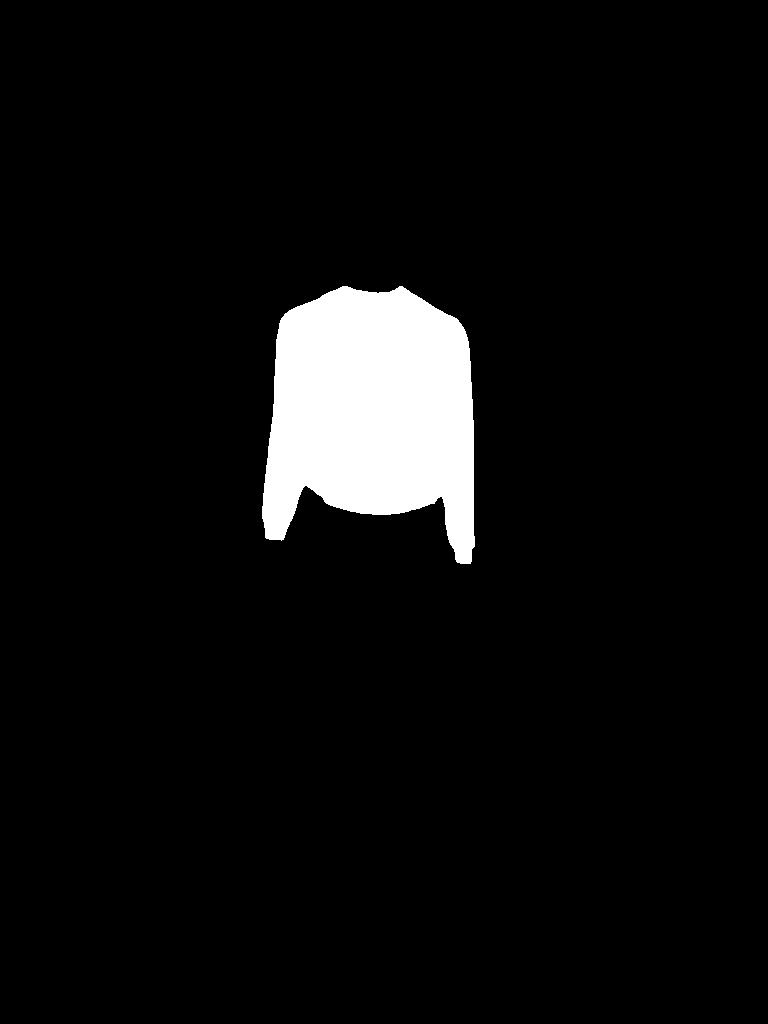

In [31]:
garment = garments["striped_sweater"]
human = humans["nimo"]

im = mask_garment(garment, human)
im.save(f"../images/masks/{human["name"]}/post/{garment["name"]}.jpg")
im

In [9]:
human = humans["nimo"]
for garment in tqdm(garments.values()):
    im = mask_garment(garment, human)
    im.save(f"../images/masks/{human["name"]}/post/{garment["name"]}.jpg")

  0%|          | 0/8 [00:00<?, ?it/s]

prompt: 'purple t-shirt'
negative_prompt: 'pants, underwear, shoes'
result: 'https://replicate.delivery/pbxt/ndPExwMav9bffkSh7R9Rf78mGSfx84FfnyrCscRywcrYxPzcC/annotated_picture_mask.jpg'
result: 'https://replicate.delivery/pbxt/DefYfK2PBGNJ4Jn8etqledihzVKeKwh3yfWuAkAfgtm7MezMnA/neg_annotated_picture_mask.jpg'
result: 'https://replicate.delivery/pbxt/0XC6cAjYB86LAlqNowwjqQaXREva0csUKEwShpYvG7MjfMzJA/mask.jpg'
prompt: 'oversized pink sweater'
negative_prompt: 'pants, underwear, shoes'
result: 'https://replicate.delivery/pbxt/1T8NKUypCiYOBZe5xMpAzBEm0rDIxgGX173fL345uaUQezMnA/annotated_picture_mask.jpg'
result: 'https://replicate.delivery/pbxt/eKRWAJjGE8S2HyaCgAxeCTyz5JdUdl9QIjWWfDQ2WfME5nZOB/neg_annotated_picture_mask.jpg'
result: 'https://replicate.delivery/pbxt/ewCj5GdcbHWuMC7oPRfxwZYseOgW5P8QnqCEnEaN9YJj8zMnA/mask.jpg'
prompt: 'black and white striped sweater'
negative_prompt: 'pants, underwear, shoes'
result: 'https://replicate.delivery/pbxt/Angc69UVLY5CJJBHrLrrBYJO0OMgXZzWa0hdKdTLfUM

### Combine garments

MPO (768, 1024) RGB
JPEG (768, 1024) RGB
JPEG (768, 1024) RGB
None (768, 1024) L


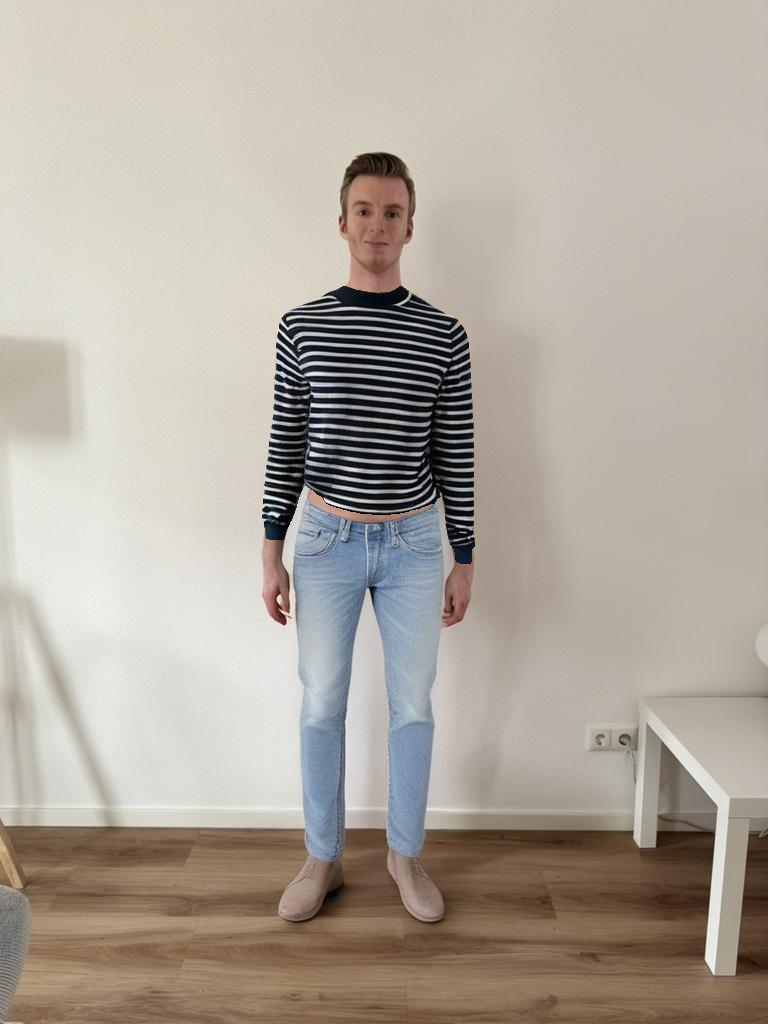

In [7]:
from combining import combine_garments

human = humans["nimo"]
garment_top = garments["striped_sweater"]
garment_bottom = garments["jeans"]

human_im = Image.open(human["image_path"])
print(human_im.format, human_im.size, human_im.mode)

result_top_im = Image.open(
    f'../images/results/{human["name"]}/single/{garment_top["name"]}.jpg'
)
print(result_top_im.format, result_top_im.size, result_top_im.mode)

result_bottom_im = Image.open(
    f'../images/results/{human["name"]}/single/{garment_bottom["name"]}.jpg'
)
print(result_bottom_im.format, result_bottom_im.size, result_bottom_im.mode)

mask_top_im = Image.open(
    f'../images/masks/{human["name"]}/post/{garment_top["name"]}.jpg'
).convert("L")
print(mask_top_im.format, mask_top_im.size, mask_top_im.mode)

im = combine_garments(human_im, result_top_im, result_bottom_im, mask_top_im)
im.save(f"../images/results/{human["name"]}/multi/{garment_top["name"]}_{garment_bottom["name"]}.jpg")
im